In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import json


import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "check_generated_data.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path, get_data_paths, setup_root_paths
setup_project_paths(PATH)

from utils_plotting import plot_time_series, plot_random_monthly_and_yearly_data, plot_feature_histograms
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
#from utils_cumulative_distribution import calculate_global_cumulative_distribution
from utils_global_probabilities import calculate_global_probabilities
from utils_country_probabilities import calculate_all_country_probabilities
from utils_return_periods import calculate_return_periods
from utils_check_expected_features import check_expected_features    
from utils_date_index import calculate_date_from_index 
from utils_country_id_csv_to_json import country_id_csv_to_json
from utils_get_country_names_by_ids import get_country_names_by_ids

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
# load save minimal dataframes and check the expected feature agian
df_monthly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_monthly.pkl")
df_yearly = pd.read_pickle("/home/simon/Documents/scripts/VIEWS_FAO_index/data/processed/pilot_return_periods_yearly.pkl")

In [4]:
country_list = df_yearly['c_id'].unique().tolist()

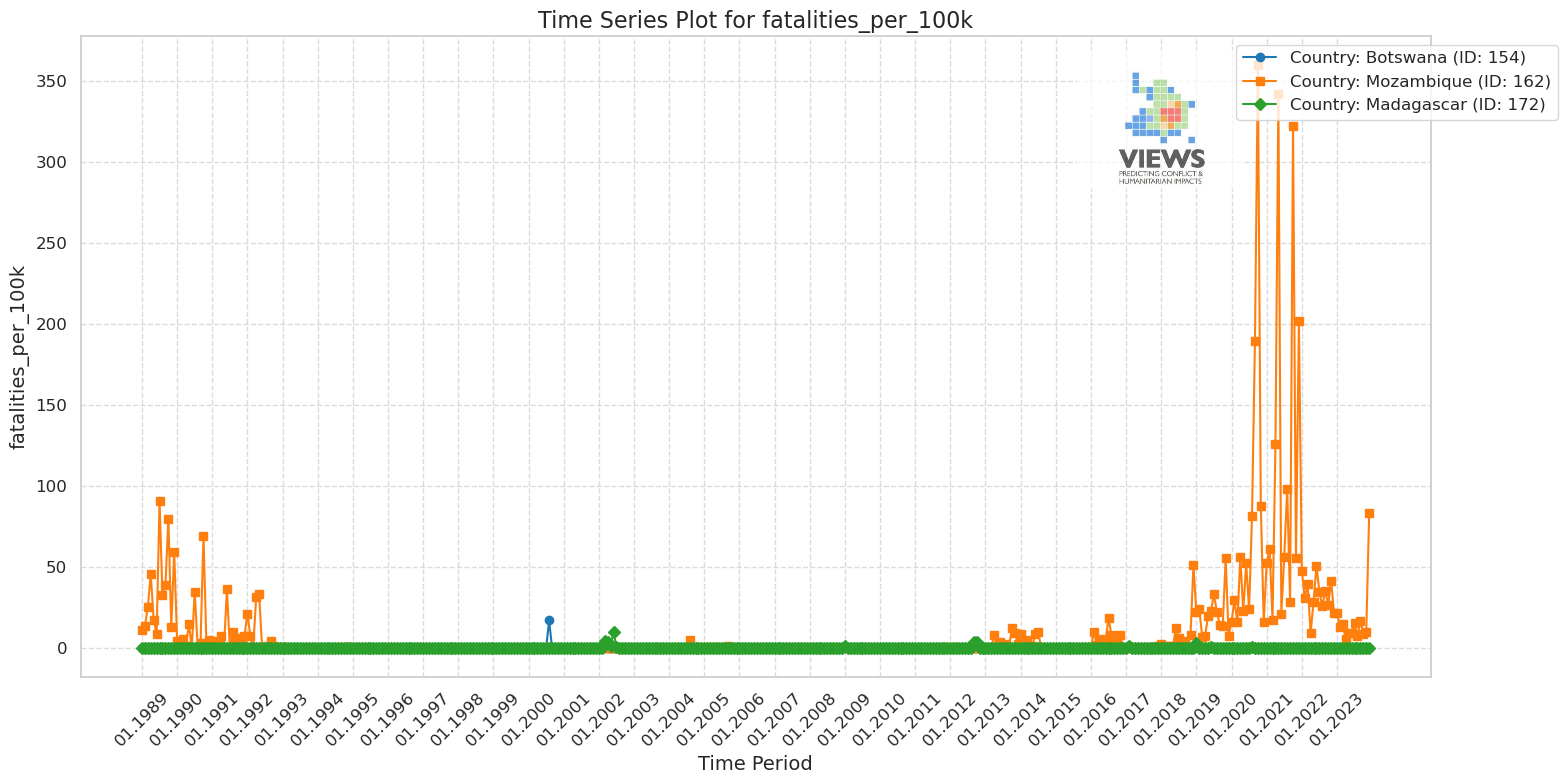

In [5]:
plot_time_series(df_monthly, country_ids=country_list[5:8], feature='fatalities_per_100k', figsize=(16, 8))

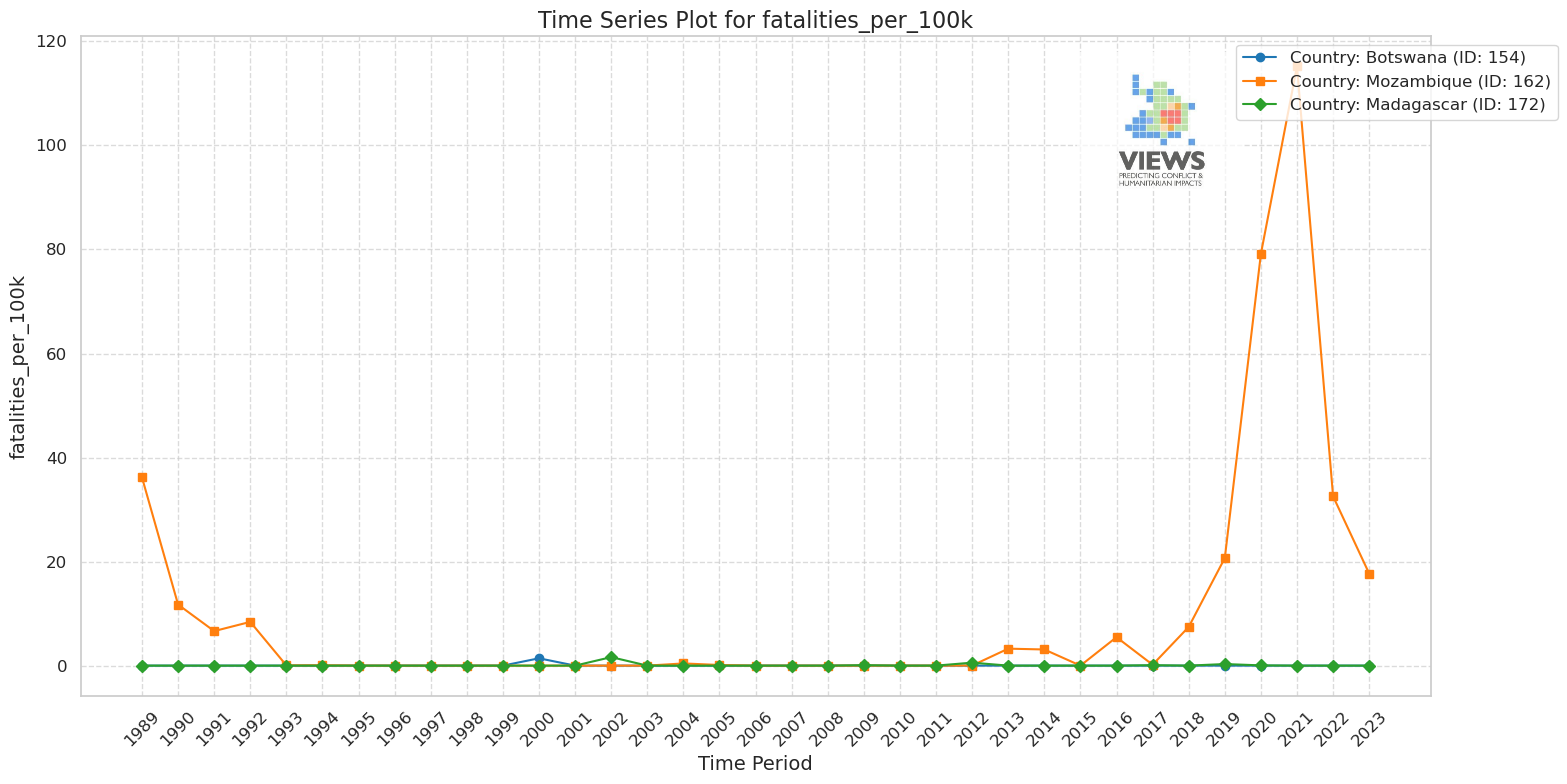

In [6]:
plot_time_series(df_yearly, country_ids=country_list[5:8], feature='fatalities_per_100k', figsize=(16, 8))

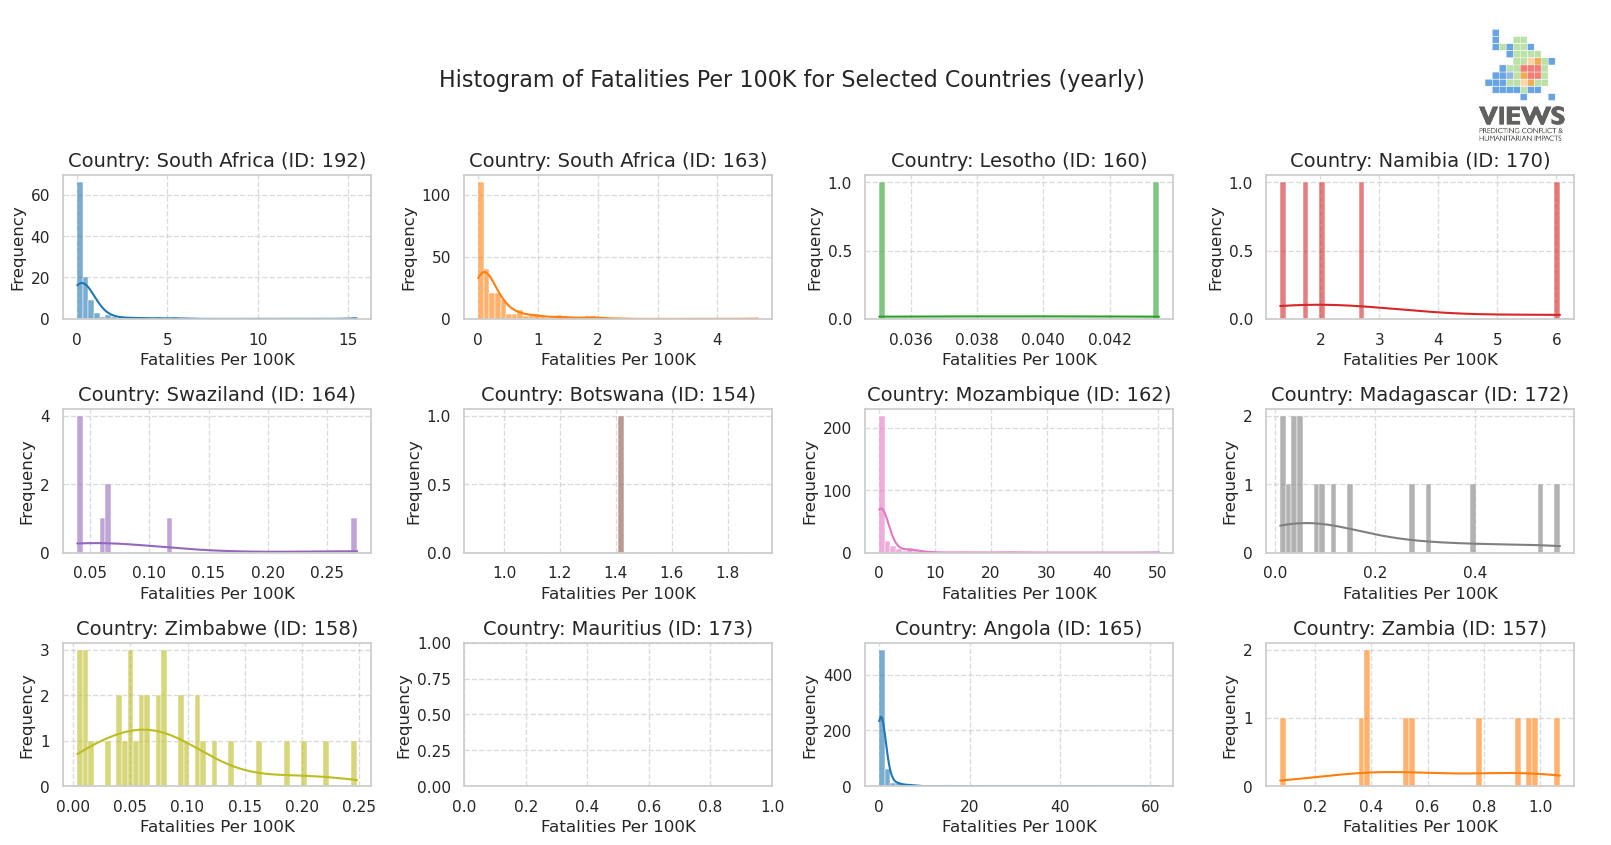

In [7]:
plot_feature_histograms(df_yearly, country_list[0:12], feature='fatalities_per_100k', figsize=(16, 8))

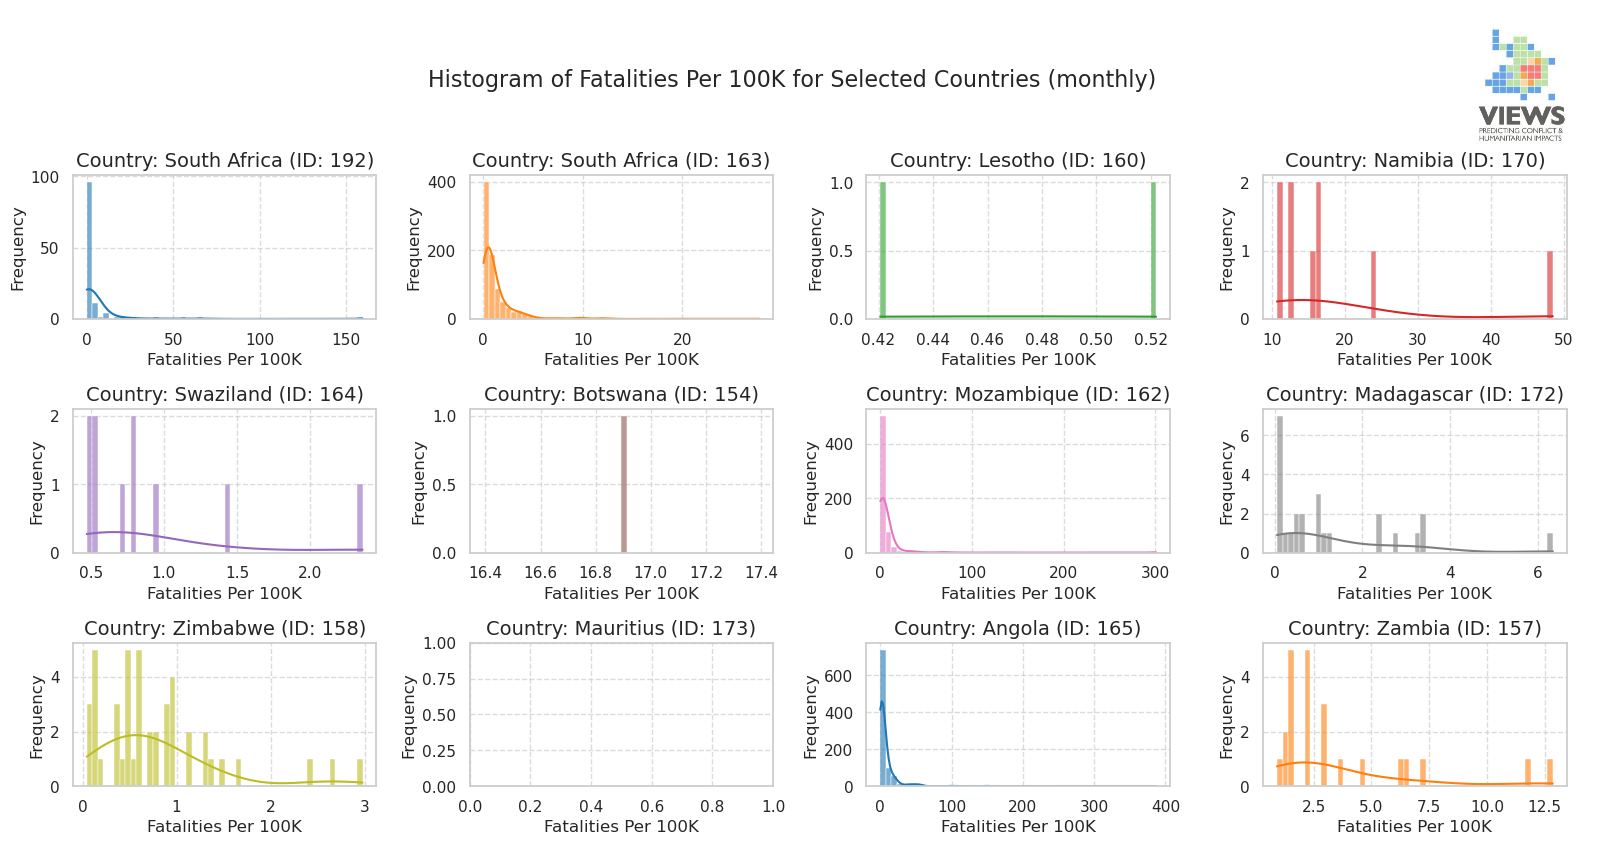

In [8]:
plot_feature_histograms(df_monthly, country_list[0:12], feature='fatalities_per_100k', figsize=(16, 8))